In [4]:
from torch import Tensor, nn

from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import requests
import os
import sys
import json
from sklearn.model_selection import train_test_split

In [5]:
model_df = pd.read_csv("model_props_with_r2_master.csv")

In [6]:
model_df.head()

,name,family,parameters,activation_function,instruct_tuned,architecture,modality,fine_tuned,training_tokens,n_layers,...,average,ifeval,bbh,math,gpqa,musr,mmlu,r2,rdm_corr,cka
0,gemma-2-2b,gemma,2B,GeGLU,False,decoder,text,False,2T,26,...,10.13,19.93,11.76,2.87,1.68,11.43,13.11,0.125507,0.034266,0.140113
1,gemma-2-2b-it,gemma,2B,GeGLU,True,decoder,text,True,2T,26,...,17.05,56.68,17.98,0.08,3.24,7.08,17.22,0.320657,0.429187,0.483059
2,gemma-2-9b,gemma,9B,GeGLU,False,decoder,text,False,8T,42,...,21.21,20.40,34.10,13.44,10.51,14.30,34.48,0.177993,0.185771,0.237628
3,gemma-2-9b-it,gemma,9B,GeGLU,True,decoder,text,True,8T,42,...,32.07,74.36,42.14,19.49,14.77,9.74,31.95,0.439693,0.579114,0.664769
4,gemma-2-27b,gemma,27B,GeGLU,False,decoder,text,False,13T,46,...,23.93,24.75,37.39,16.62,13.42,13.92,37.45,0.368882,0.527818,0.585488


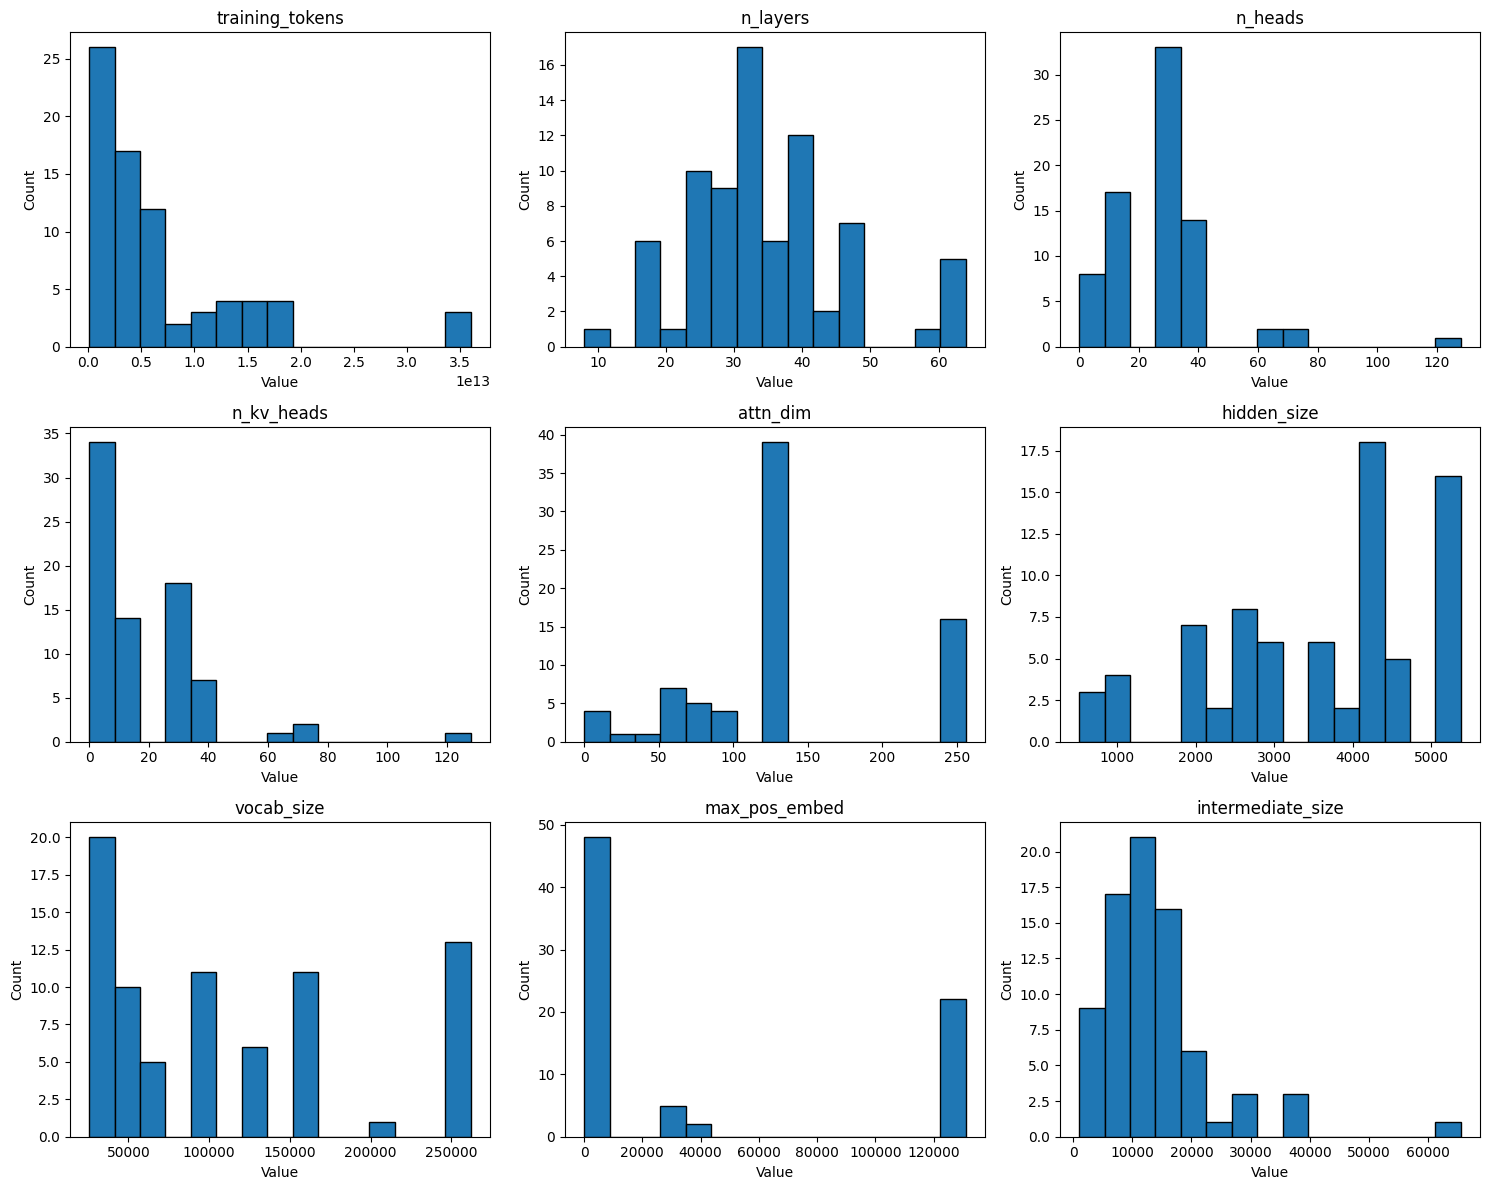

In [7]:
import matplotlib.pyplot as plt

# Columns you want to plot
cols = [
    "training_tokens", "n_layers", "n_heads", "n_kv_heads",
    "attn_dim", "hidden_size", "vocab_size",
    "max_pos_embed", "intermediate_size"
]

# Ensure numeric (handles things like '2T', '8T', etc. if present)
def to_number(x):
    if isinstance(x, str):
        x = x.replace("T", "e12").replace("B", "e9")  # rough conversion
        try:
            return float(eval(x))
        except:
            return None
    return x

for c in cols:
    model_df[c] = model_df[c].apply(to_number)

# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].hist(model_df[col].dropna(), bins=15, edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


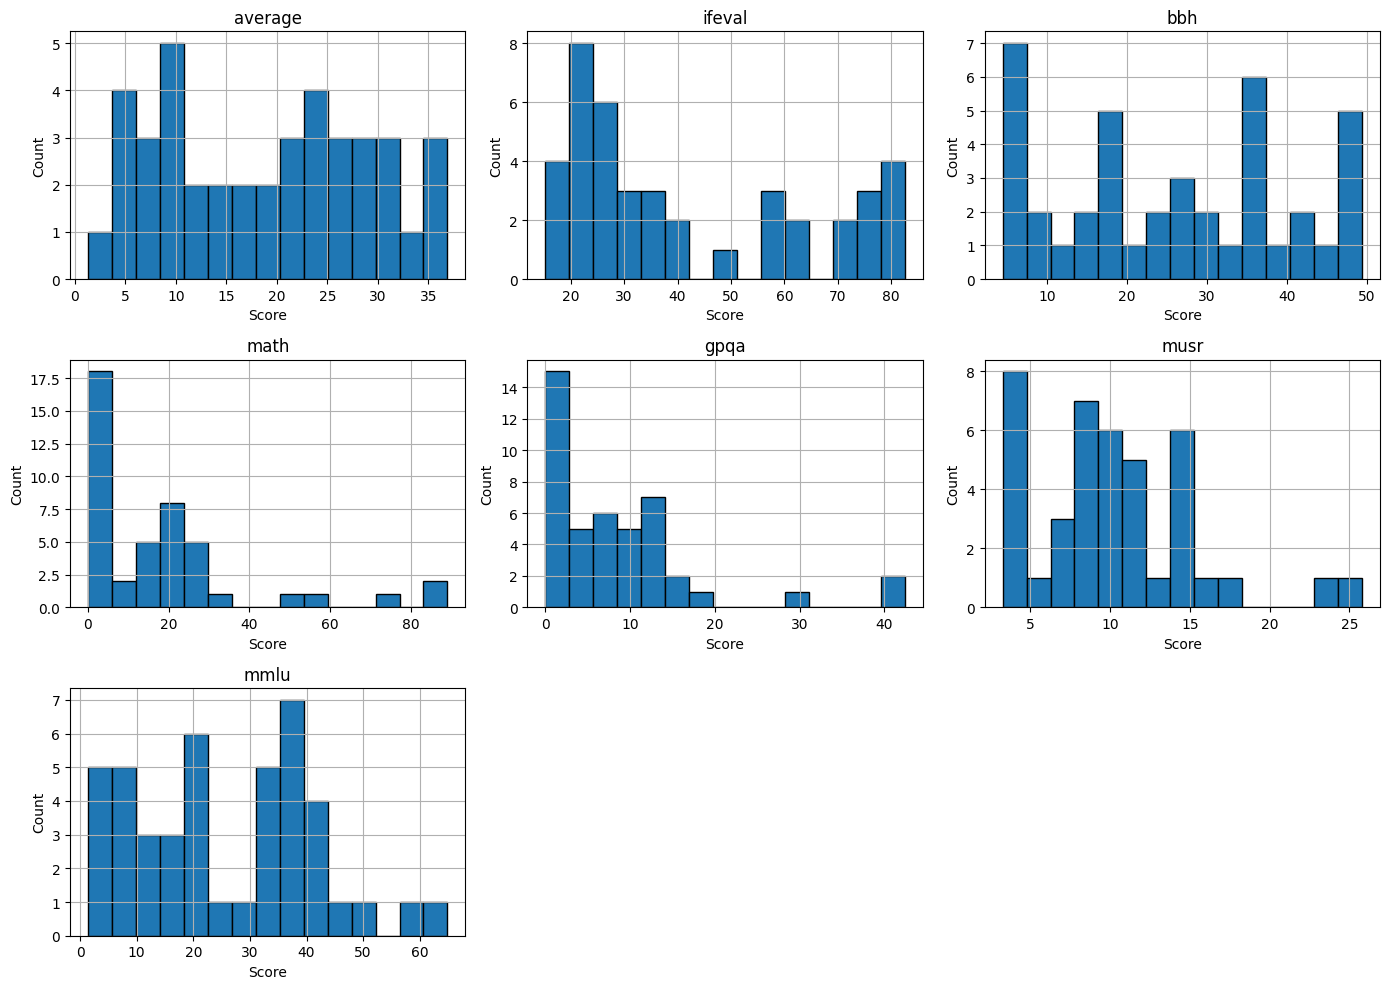

In [8]:
import matplotlib.pyplot as plt

cols = ["average", "ifeval", "bbh", "math", "gpqa", "musr", "mmlu"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i)  # 3x3 grid, adjust as needed
    model_df[col].hist(bins=15, edgecolor="black")
    plt.title(col)
    plt.xlabel("Score")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [9]:
print(len(model_df))



77


/tmp/ipykernel_873219/2138322912.py:20: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  model_df["modality"] = model_df["modality"].replace({"multimodal": "multi"})


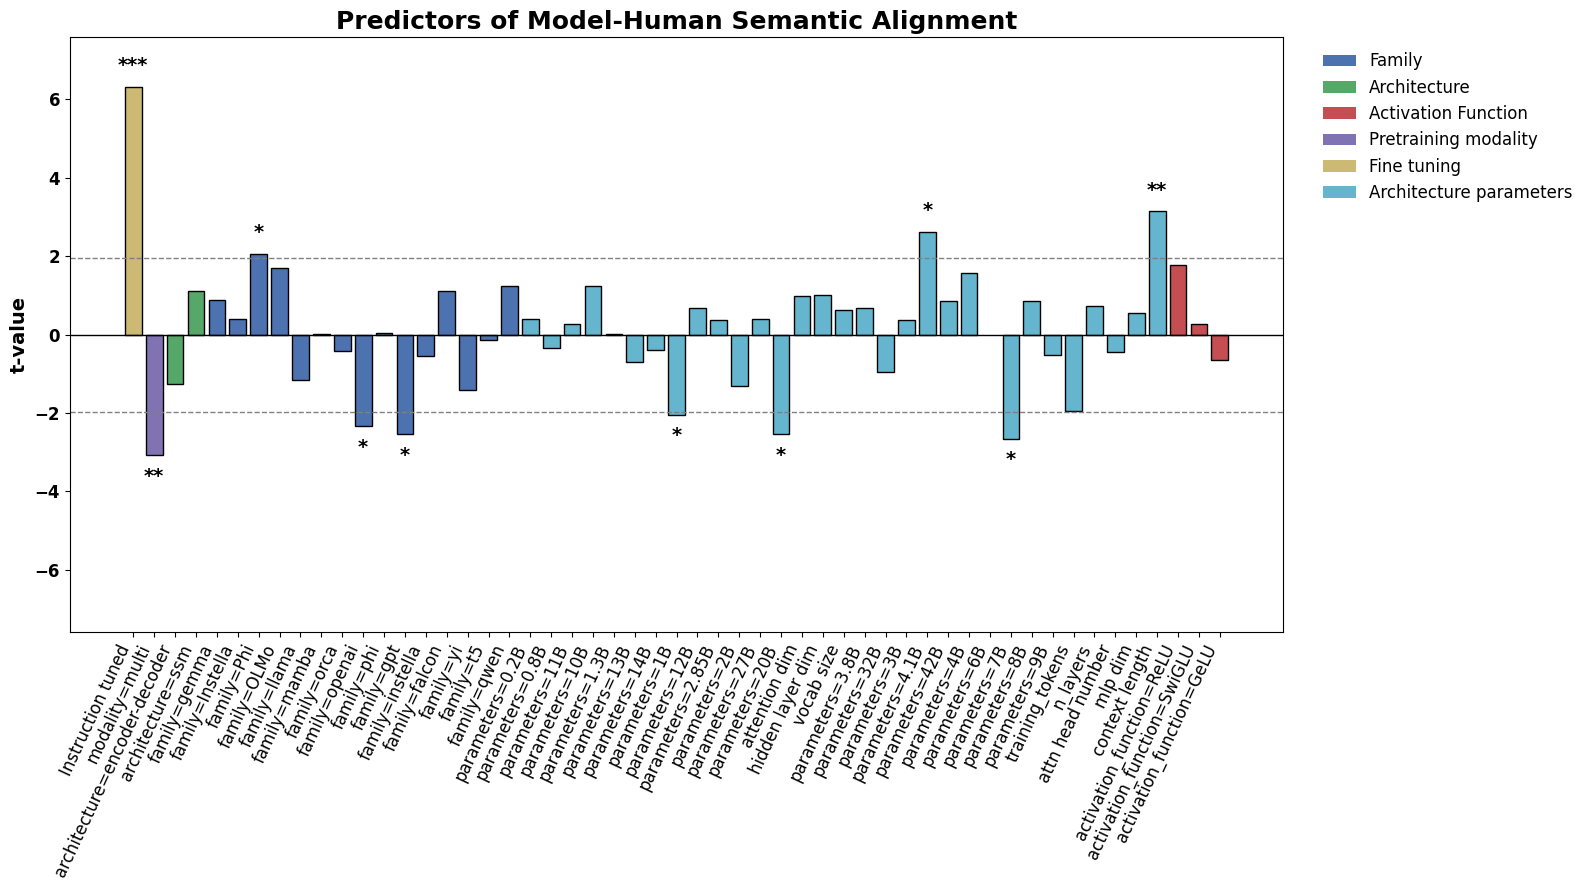

In [22]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import statsmodels.formula.api as smf
import pandas as pd

# --- Helper to safely reorder categories ---
def safe_reorder(series, new_order):
    cats = list(series.cat.categories)
    # keep only categories that exist
    valid_order = [c for c in new_order if c in cats]
    # add any leftover categories at the end
    remainder = [c for c in cats if c not in valid_order]
    final_order = valid_order + remainder
    return series.cat.reorder_categories(final_order, ordered=False)

# --- Change baselines for categorical predictors ---
# modality
model_df["modality"] = model_df["modality"].replace({"multimodal": "multi"})
model_df["modality"] = model_df["modality"].astype("category")
model_df["modality"] = safe_reorder(model_df["modality"], ["text", "multi"])

# family
model_df["family"] = model_df["family"].astype("category")
model_df["family"] = safe_reorder(
    model_df["family"],
    ["flan"] + [c for c in model_df["family"].cat.categories if c != "flan"]
)

# --- Regression formula ---
formula = """r2 ~ family + architecture + activation_function 
             + modality + instruct_tuned 
             + training_tokens + parameters + n_layers + n_heads 
             + attn_dim + hidden_size + vocab_size 
             + max_pos_embed + intermediate_size"""

model = smf.ols(formula=formula, data=model_df).fit()

# --- Get t-values and p-values ---
tvals = model.tvalues.drop("Intercept")
pvals = model.pvalues.drop("Intercept")

# --- Function to map p-values to stars ---
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

stars = pvals.apply(p_to_stars)

# --- Clean labels properly ---
clean_index = []
for idx in tvals.index:
    match = re.match(r"(.*)\[T\.(.*)\]", idx)
    if match:
        var, val = match.groups()
        label = f"{var}={val}"
    else:
        label = idx
    clean_index.append(label)

# --- Custom replacements ---
replace_map = {
    "multi": "multimodal pretraining",
    "instruct_tuned=True": "Instruction tuned"
}
clean_index = [replace_map.get(lbl, lbl) for lbl in clean_index]

# --- Mapping for continuous predictor renames ---
rename_map = {
    "n_heads": "attn head number",
    "attn_dim": "attention dim",
    "hidden_size": "hidden layer dim",
    "vocab_size": "vocab size",
    "max_pos_embed": "context length",
    "intermediate_size": "mlp dim"
}
clean_index = [rename_map.get(lbl, lbl) for lbl in clean_index]

# --- Color mapping by variable type (appealing palette) ---
color_map = {
    "family": "#4C72B0",
    "architecture": "#55A868",
    "activation_function": "#C44E52",
    "modality": "#8172B3",
    "instruct_tuned": "#CCB974",
    "default": "#64B5CD"
}

def get_group(idx):
    for key in color_map.keys():
        if idx.startswith(key) or idx.startswith(f"{key}="):
            return key
    return "default"

def get_color(idx):
    return color_map[get_group(idx)]

# --- Build dataframe for sorting ---
plot_df = pd.DataFrame({
    "label": clean_index,
    "tval": tvals.values,
    "pval": pvals.values,
    "stars": stars.values,
    "group": [get_group(idx) for idx in tvals.index],
    "color": [get_color(idx) for idx in tvals.index]
})

# compute mean abs(t) per group
group_order = (
    plot_df.groupby("group")["tval"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index.tolist()
)

# reorder within groups
plot_df["group_order"] = plot_df["group"].map({g: i for i, g in enumerate(group_order)})
plot_df = plot_df.sort_values(["group_order"]).reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(16, 9))

bars = plt.bar(plot_df["label"], plot_df["tval"],
               color=plot_df["color"], edgecolor="black")

# add significance stars
for i, (val, star) in enumerate(zip(plot_df["tval"], plot_df["stars"])):
    if star:
        plt.text(i, val + np.sign(val)*0.3, star, ha="center",
                 va="bottom" if val > 0 else "top",
                 fontsize=14, fontweight="bold", color="black")

# add padding above tallest bar
ymax = max(plot_df["tval"].max(), abs(plot_df["tval"].min()))
plt.ylim(-ymax * 1.2, ymax * 1.2)

plt.axhline(0, color="black", linewidth=1)
plt.axhline(1.96, color="gray", linestyle="--", linewidth=1)
plt.axhline(-1.96, color="gray", linestyle="--", linewidth=1)

plt.title("Predictors of Model-Human Semantic Alignment", fontsize=18, fontweight="bold")
plt.ylabel("t-value", fontsize=14, fontweight="bold")

plt.xticks(rotation=65, ha="right", fontsize=12, fontweight="normal")
plt.yticks(fontsize=12, fontweight="bold")

# --- Add legend ---
legend_elements = [
    Patch(facecolor=color_map["family"], label="Family"),
    Patch(facecolor=color_map["architecture"], label="Architecture"),
    Patch(facecolor=color_map["activation_function"], label="Activation Function"),
    Patch(facecolor=color_map["modality"], label="Pretraining modality"),
    Patch(facecolor=color_map["instruct_tuned"], label="Fine tuning"),
    Patch(facecolor=color_map["default"], label="Architecture parameters")
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc="upper left",
           fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig("t_scores_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [15]:
# find family with highest mean r2
family_means = model_df.groupby("family")["r2"].mean().sort_values(ascending=False)
print(family_means)

top_family = family_means.index[0]
print("Family with highest average r2:", top_family)


family
Phi         0.468913
phi         0.394414
qwen        0.350189
orca        0.328817
Instella    0.302573
llama       0.288248
gemma       0.277121
OLMo        0.274646
falcon      0.241852
flan        0.216344
instella    0.106140
t5          0.098598
yi          0.090551
gpt         0.086543
mamba       0.079645
openai      0.024608
Name: r2, dtype: float64
Family with highest average r2: Phi


In [17]:
cols = [
    "r2", "family", "architecture", "activation_function", 
    "modality", "instruct_tuned", 
    "training_tokens", "parameters", "n_layers", "n_heads", 
    "attn_dim", "hidden_size", "vocab_size", 
    "max_pos_embed", "intermediate_size"
]

print(model_df[cols].isna().sum())


r2                     0
family                 0
architecture           0
activation_function    9
modality               0
instruct_tuned         0
training_tokens        2
parameters             0
n_layers               0
n_heads                0
attn_dim               0
hidden_size            0
vocab_size             0
max_pos_embed          0
intermediate_size      0
dtype: int64


In [18]:
cols = [
    "r2", "family", "architecture", "activation_function", 
    "modality", "instruct_tuned", 
    "training_tokens", "parameters", "n_layers", "n_heads", 
    "attn_dim", "hidden_size", "vocab_size", 
    "max_pos_embed", "intermediate_size"
]

# Count rows that have at least one missing among these
n_missing_rows = model_df[cols].isna().any(axis=1).sum()
print("Rows with at least one missing value:", n_missing_rows)


Rows with at least one missing value: 11


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Predictor variables ---
predictors = [
    "training_tokens", "parameters", "n_layers", "n_heads",
    "attn_dim", "hidden_size", "vocab_size",
    "max_pos_embed", "intermediate_size"
]

# --- Label mappings ---
rename_map = {
    "training_tokens": "Training tokens",
    "parameters": "Parameters",
    "n_layers": "Layers",
    "n_heads": "Attn head number",
    "attn_dim": "Attention dim",
    "hidden_size": "Hidden layer dim",
    "vocab_size": "Vocab size",
    "max_pos_embed": "Context length",
    "intermediate_size": "MLP dim"
}

# Melt into long format
df_long = model_df.melt(
    id_vars="r2", 
    value_vars=predictors,
    var_name="Predictor", value_name="Value"
)

# --- Apply label mappings ---
df_long["Predictor"] = df_long["Predictor"].map(rename_map).fillna(df_long["Predictor"])

# --- filter out 1.5 IQR outliers per predictor ---
def drop_outliers(group):
    q1 = group["Value"].quantile(0.25)
    q3 = group["Value"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group["Value"] >= lower) & (group["Value"] <= upper)]

df_long_filtered = df_long.groupby("Predictor", group_keys=False).apply(drop_outliers)

# --- Facet grid: stack vertically with stretched x-axis ---
g = sns.lmplot(
    data=df_long_filtered,
    x="Value", y="r2",
    col="Predictor",
    col_wrap=1,                # one column = stacked vertically
    sharex=False, sharey=False,
    height=2.2, aspect=4.0,    # stretched horizontally
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"color": "red"}
)

g.set_titles("{col_name}")
g.set_axis_labels("Value", "r²")

plt.tight_layout()

# --- Save as PDF ---
plt.savefig("predictor_correlations.pdf", format="pdf", bbox_inches="tight")

plt.show()


TypeError: unsupported operand type(s) for -: 'str' and 'str'

/mnt/dv/wid/projects3/Rogers-muri-human-ai/zstuddiford/tmp/miniconda3/envs/alignment_benchmark_env/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/mnt/dv/wid/projects3/Rogers-muri-human-ai/zstuddiford/tmp/miniconda3/envs/alignment_benchmark_env/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


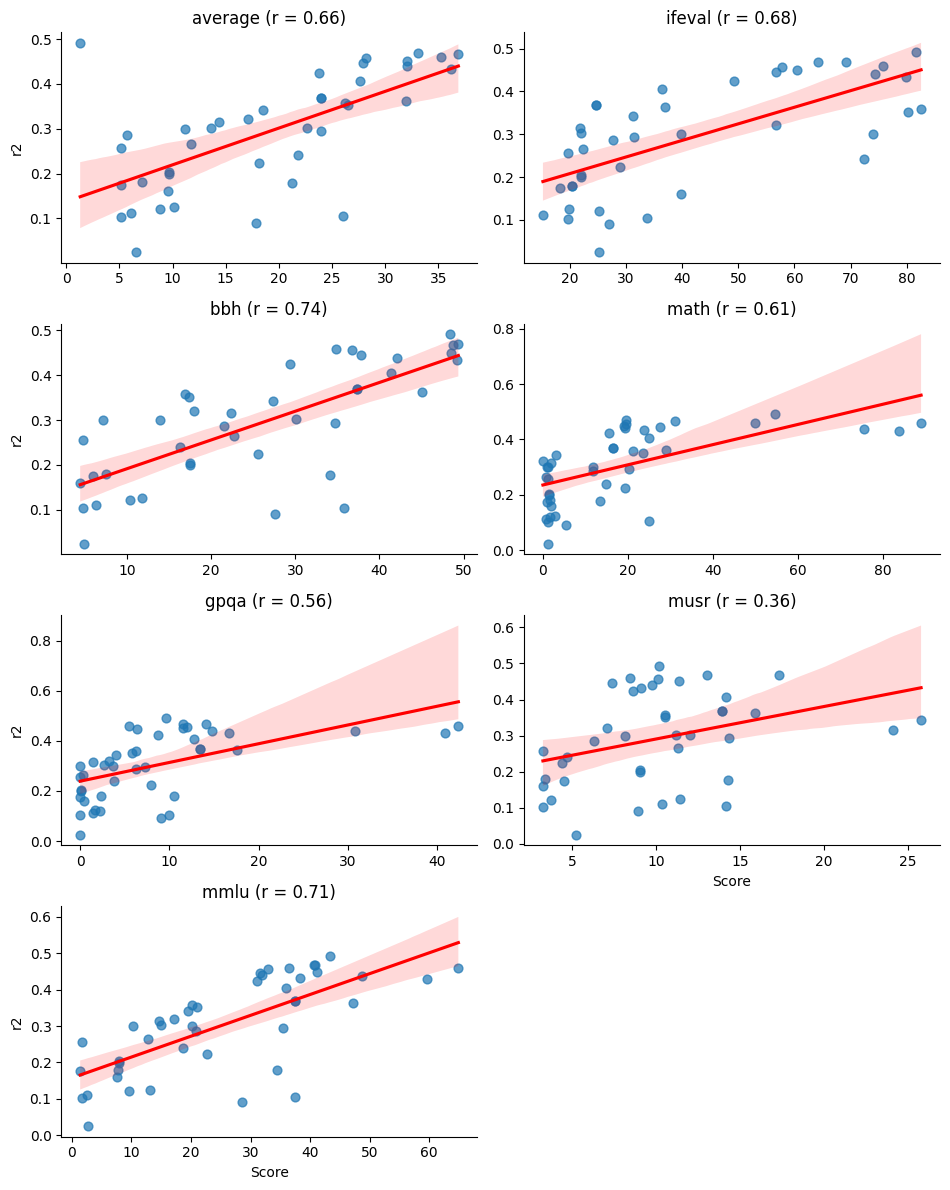

Pearson correlations with r2:
average: 0.657
ifeval: 0.680
bbh: 0.737
math: 0.613
gpqa: 0.558
musr: 0.355
mmlu: 0.714


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# benchmarks to plot
benchmarks = ["average", "ifeval", "bbh", "math", "gpqa", "musr", "mmlu"]

# calculate correlations
corrs = {b: model_df["r2"].corr(model_df[b]) for b in benchmarks}

# melt into long format
df_long = model_df.melt(
    id_vars="r2",
    value_vars=benchmarks,
    var_name="Benchmark", value_name="Score"
)

# Facet: 2 per row, separate axes
g = sns.lmplot(
    data=df_long,
    x="Score", y="r2",
    col="Benchmark",
    col_wrap=2,
    sharex=False, sharey=False,
    height=3, aspect=1.6,
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"color": "red"}
)

# set titles with correlation values
for ax, bench in zip(g.axes.flatten(), df_long["Benchmark"].unique()):
    r = corrs[bench]
    ax.set_title(f"{bench} (r = {r:.2f})")

g.set_axis_labels("Score", "r2")
plt.tight_layout()
plt.show()

# also print raw correlation values
print("Pearson correlations with r2:")
for b, r in corrs.items():
    print(f"{b}: {r:.3f}")


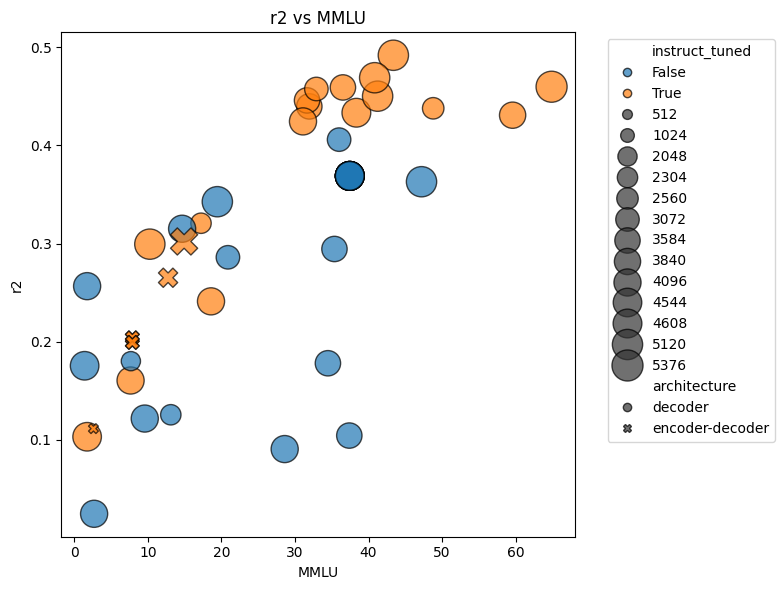

Number of points displayed: 47


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows where required values are missing
plot_df = model_df.dropna(subset=["mmlu", "r2", "hidden_size"])

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=plot_df,
    x="mmlu", y="r2",
    hue="instruct_tuned",       # color
    style="architecture",       # shape
    size="hidden_size",         # bubble size
    sizes=(50, 500),
    alpha=0.7,
    edgecolor="black",
    legend="full"
)

# remove hidden_size size legend
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
for h, l in zip(handles, labels):
    if "hidden_size" not in l:   # filter out size legend entries
        new_handles.append(h)
        new_labels.append(l)
ax.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("r2 vs MMLU")
plt.xlabel("MMLU")
plt.ylabel("r2")
plt.tight_layout()
plt.show()

# print number of displayed points
print(f"Number of points displayed: {len(plot_df)}")


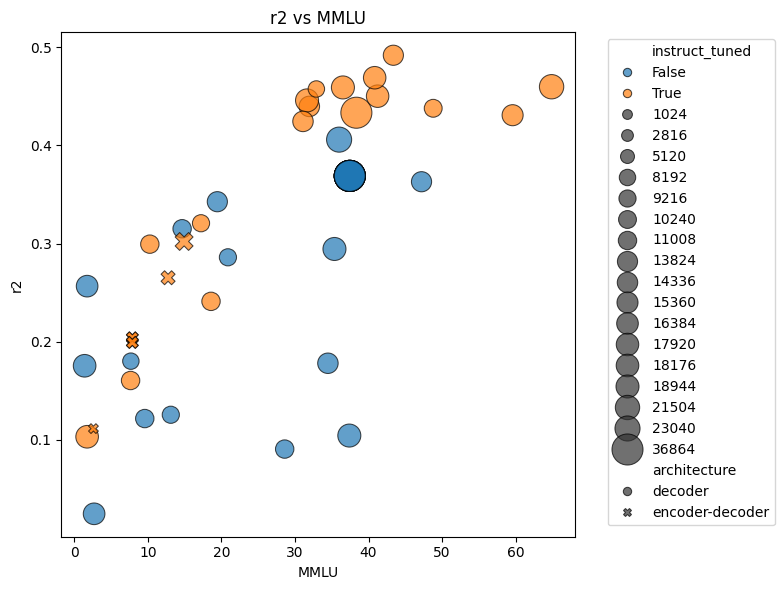

Number of points displayed: 47


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows where required values are missing
plot_df = model_df.dropna(subset=["mmlu", "r2", "intermediate_size"])

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=plot_df,
    x="mmlu", y="r2",
    hue="instruct_tuned",       # color
    style="architecture",       # shape
    size="intermediate_size",   # bubble size
    sizes=(50, 500),
    alpha=0.7,
    edgecolor="black",
    legend="full"
)

# remove intermediate_size size legend
handles, labels = ax.get_legend_handles_labels()
new_handles, new_labels = [], []
for h, l in zip(handles, labels):
    if "intermediate_size" not in l:   # filter out size legend entries
        new_handles.append(h)
        new_labels.append(l)
ax.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("r2 vs MMLU")
plt.xlabel("MMLU")
plt.ylabel("r2")
plt.tight_layout()
plt.show()

# print number of displayed points
print(f"Number of points displayed: {len(plot_df)}")


In [15]:
model_df

,name,family,parameters,activation_function,instruct_tuned,architecture,modality,fine_tuned,average,ifeval,...,n_layers,n_heads,n_kv_heads,attn_dim,hidden_size,vocab_size,max_pos_embed,intermediate_size,rdm_corr,cka
0,gemma-2-2b,gemma,2B,GeGLU,False,decoder,text,False,10.13,19.93,...,26,8,4,256,2304,256000,8192,9216,0.034266,0.140113
1,gemma-2-2b-it,gemma,2B,GeGLU,True,decoder,text,True,17.05,56.68,...,26,8,4,256,2304,256000,8192,9216,0.429187,0.483059
2,gemma-2-9b,gemma,9B,GeGLU,False,decoder,text,False,21.21,20.40,...,42,16,8,256,3584,25600,8192,14336,0.185771,0.237628
3,gemma-2-9b-it,gemma,9B,GeGLU,True,decoder,text,True,32.07,74.36,...,42,16,8,256,3584,25600,8192,14336,0.579114,0.664769
4,gemma-2-27b,gemma,27B,GeGLU,False,decoder,text,False,23.93,24.75,...,46,32,16,128,4608,256000,8192,36864,0.527818,0.585488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,amd/Instella-3B,Instella,3B,NaN,False,decoder,text,False,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.367493,0.417895
69,amd/Instella-3B-SFT,Instella,3B,NaN,True,decoder,text,True,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.449639,0.427776
70,AMD-OLMo-1B-SFT-DPO,OLMo,1B,SwiGLU,True,decoder,text,True,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.071649,0.115362
71,AMD-OLMo-1B,OLMo,1B,SwiGLU,False,decoder,text,False,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.051264,0.130871


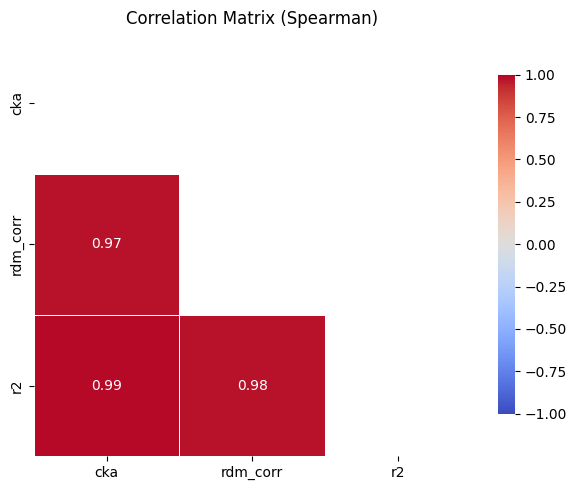

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select only the three metrics
corr = model_df[["cka", "rdm_corr", "r2"]].corr(method="spearman")

# Mask to show only upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6, 5))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix (Spearman)")
plt.tight_layout()
plt.show()


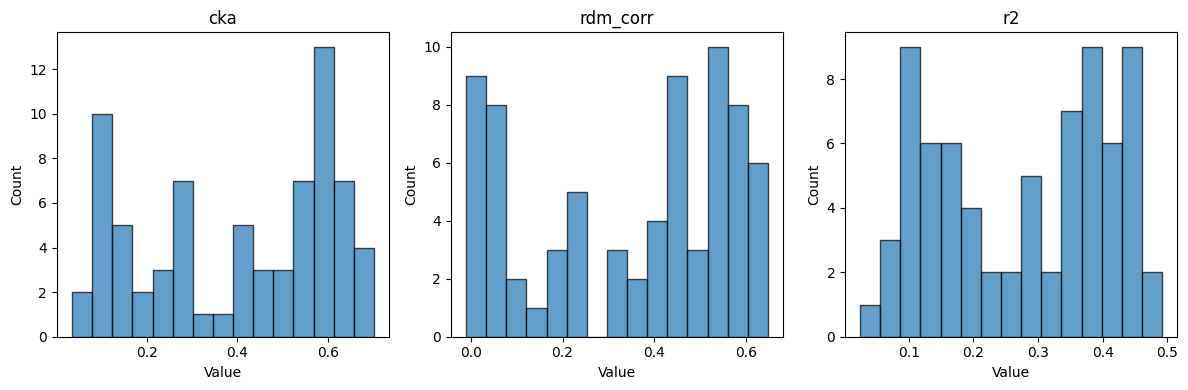

In [17]:
import matplotlib.pyplot as plt

metrics = ["cka", "rdm_corr", "r2"]

plt.figure(figsize=(12, 4))

for i, m in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.hist(model_df[m].dropna(), bins=15, edgecolor="black", alpha=0.7)
    plt.title(m)
    plt.xlabel("Value")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


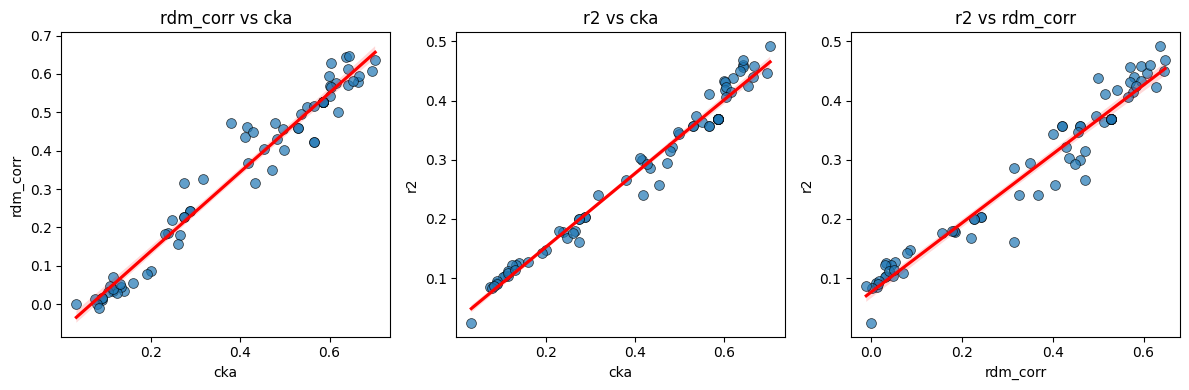

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

metrics = ["cka", "rdm_corr", "r2"]
pairs = list(itertools.combinations(metrics, 2))

plt.figure(figsize=(12, 4))

for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=model_df, x=x, y=y, s=50, alpha=0.7, edgecolor="black")
    sns.regplot(data=model_df, x=x, y=y, scatter=False, color="red")  # regression line
    plt.title(f"{y} vs {x}")

plt.tight_layout()
plt.show()


In [31]:
model_df.columns

Index(['name', 'family', 'parameters', 'activation_function', 'instruct_tuned',
       'architecture', 'modality', 'fine_tuned', 'average', 'ifeval', 'bbh',
       'math', 'gpqa', 'musr', 'mmlu', 'r2', 'training_tokens', 'n_layers',
       'n_heads', 'n_kv_heads', 'attn_dim', 'hidden_size', 'vocab_size',
       'max_pos_embed', 'intermediate_size', 'rdm_corr', 'cka'],
      dtype='object')

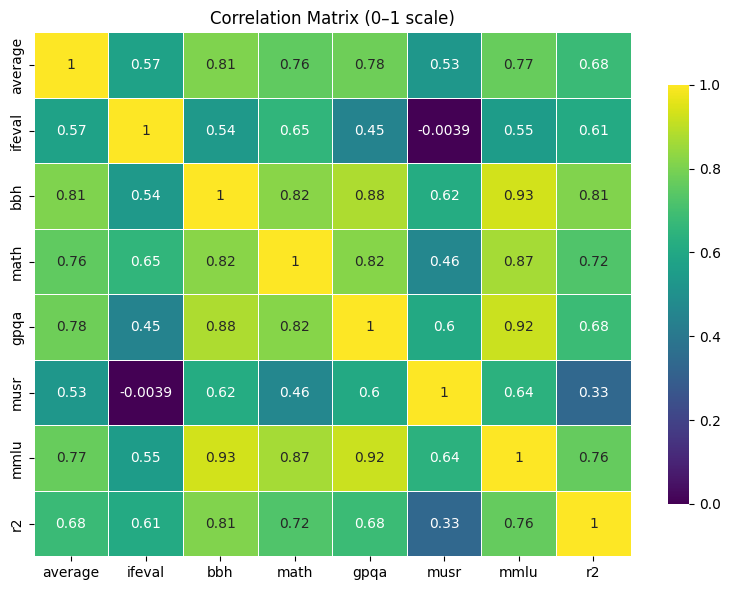

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ["average", "ifeval", "bbh", "math", "gpqa", "musr", "mmlu", "r2"]

# Spearman correlation
corr = model_df[cols].corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="viridis", vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix (0–1 scale)")
plt.tight_layout()
plt.show()


In [20]:
model_df

,name,family,parameters,activation_function,instruct_tuned,architecture,modality,fine_tuned,average,ifeval,...,n_layers,n_heads,n_kv_heads,attn_dim,hidden_size,vocab_size,max_pos_embed,intermediate_size,rdm_corr,cka
0,gemma-2-2b,gemma,2B,GeGLU,False,decoder,text,False,10.13,19.93,...,26,8,4,256,2304,256000,8192,9216,0.034266,0.140113
1,gemma-2-2b-it,gemma,2B,GeGLU,True,decoder,text,True,17.05,56.68,...,26,8,4,256,2304,256000,8192,9216,0.429187,0.483059
2,gemma-2-9b,gemma,9B,GeGLU,False,decoder,text,False,21.21,20.40,...,42,16,8,256,3584,25600,8192,14336,0.185771,0.237628
3,gemma-2-9b-it,gemma,9B,GeGLU,True,decoder,text,True,32.07,74.36,...,42,16,8,256,3584,25600,8192,14336,0.579114,0.664769
4,gemma-2-27b,gemma,27B,GeGLU,False,decoder,text,False,23.93,24.75,...,46,32,16,128,4608,256000,8192,36864,0.527818,0.585488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,amd/Instella-3B,Instella,3B,NaN,False,decoder,text,False,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.367493,0.417895
69,amd/Instella-3B-SFT,Instella,3B,NaN,True,decoder,text,True,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.449639,0.427776
70,AMD-OLMo-1B-SFT-DPO,OLMo,1B,SwiGLU,True,decoder,text,True,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.071649,0.115362
71,AMD-OLMo-1B,OLMo,1B,SwiGLU,False,decoder,text,False,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.051264,0.130871


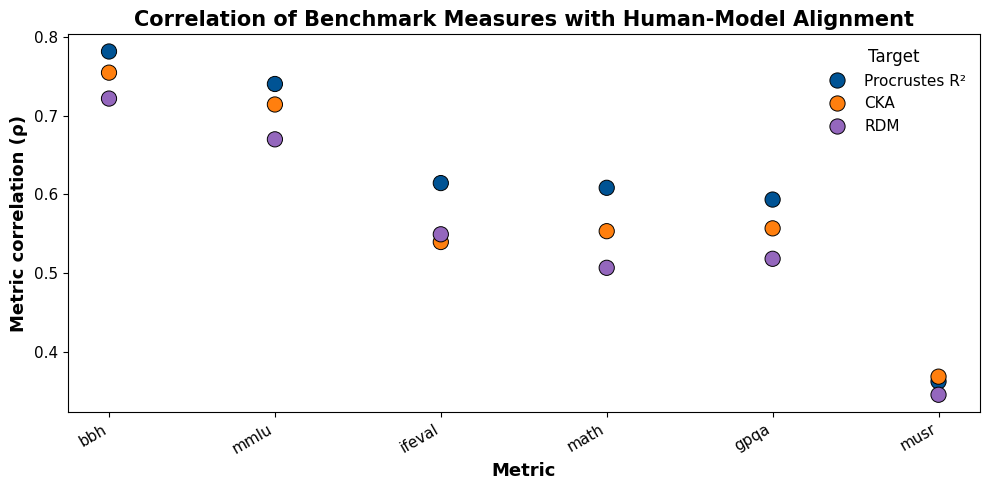

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Metrics on x-axis
metrics = ["ifeval", "bbh", "math", "gpqa", "musr", "mmlu"]

# Targets to correlate against
targets = ["r2", "cka", "rdm_corr"]

results = []
for target in targets:
    for m in metrics:
        x = model_df[m].values
        y = model_df[target].values
        mask = np.isfinite(x) & np.isfinite(y)
        x, y = x[mask], y[mask]
        corr_obs, _ = pearsonr(x, y)
        results.append({"metric": m, "target": target, "corr": corr_obs})

results_df = pd.DataFrame(results)

# --- Sort metrics by their Procrustes R² correlation (highest → lowest) ---
order = (
    results_df.query("target == 'r2'")
    .sort_values("corr", ascending=False)["metric"]
    .tolist()
)

# enforce categorical order
results_df["metric"] = pd.Categorical(results_df["metric"], categories=order, ordered=True)

# --- Sexy custom palette ---
sexy_palette = {
    "r2": "#005394",       # deep blue
    "cka": "#FF7F0E",      # orange
    "rdm_corr": "#9467BD"  # purple
}

# Legend rename map
legend_map = {
    "r2": "Procrustes R²",
    "cka": "CKA",
    "rdm_corr": "RDM"
}

# --- Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=results_df,
    x="metric", y="corr",
    hue="target", palette=sexy_palette,
    s=120, marker="o", edgecolor="black", linewidth=0.7
)

plt.xlabel("Metric", fontsize=13, fontweight="bold")
plt.ylabel("Metric correlation (ρ)", fontsize=13, fontweight="bold")
plt.title("Correlation of Benchmark Measures with Human-Model Alignment", fontsize=15, fontweight="bold")
plt.xticks(rotation=30, ha="right", fontsize=11)
plt.yticks(fontsize=11)

# customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
labels = [legend_map.get(lbl, lbl) for lbl in labels]
plt.legend(handles, labels, title="Target", fontsize=11, title_fontsize=12, frameon=False)

plt.tight_layout()

# save to pdf
plt.savefig("metric_correlations_iclr_sorted.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [36]:
model_df

,name,family,parameters,activation_function,instruct_tuned,architecture,modality,fine_tuned,average,ifeval,...,n_layers,n_heads,n_kv_heads,attn_dim,hidden_size,vocab_size,max_pos_embed,intermediate_size,rdm_corr,cka
0,gemma-2-2b,gemma,2B,GeGLU,False,decoder,text,False,10.13,19.93,...,26,8,4,256,2304,256000,8192,9216,0.034266,0.140113
1,gemma-2-2b-it,gemma,2B,GeGLU,True,decoder,text,True,17.05,56.68,...,26,8,4,256,2304,256000,8192,9216,0.429187,0.483059
2,gemma-2-9b,gemma,9B,GeGLU,False,decoder,text,False,21.21,20.40,...,42,16,8,256,3584,25600,8192,14336,0.185771,0.237628
3,gemma-2-9b-it,gemma,9B,GeGLU,True,decoder,text,True,32.07,74.36,...,42,16,8,256,3584,25600,8192,14336,0.579114,0.664769
4,gemma-2-27b,gemma,27B,GeGLU,False,decoder,text,False,23.93,24.75,...,46,32,16,128,4608,256000,8192,36864,0.527818,0.585488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,amd/Instella-3B,Instella,3B,NaN,False,decoder,text,False,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.367493,0.417895
69,amd/Instella-3B-SFT,Instella,3B,NaN,True,decoder,text,True,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.449639,0.427776
70,AMD-OLMo-1B-SFT-DPO,OLMo,1B,SwiGLU,True,decoder,text,True,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.071649,0.115362
71,AMD-OLMo-1B,OLMo,1B,SwiGLU,False,decoder,text,False,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.051264,0.130871


/tmp/ipykernel_65838/4247764524.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="name", y="r2", palette="viridis", edgecolor="black")


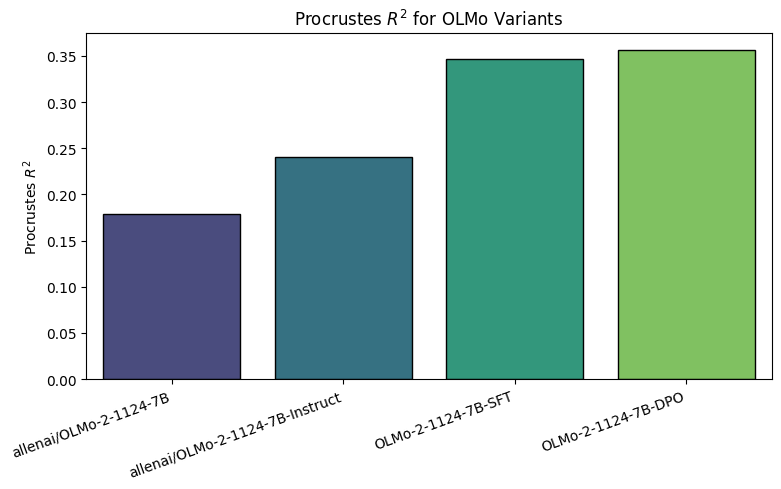

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

models_to_plot = [
    "allenai/OLMo-2-1124-7B",
    "allenai/OLMo-2-1124-7B-Instruct",
    "OLMo-2-1124-7B-SFT",
    "OLMo-2-1124-7B-DPO"
]

plot_df = model_df[model_df["name"].isin(models_to_plot)].copy()
plot_df["name"] = pd.Categorical(plot_df["name"], categories=models_to_plot, ordered=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x="name", y="r2", palette="viridis", edgecolor="black")
plt.ylabel("Procrustes $R^2$")
plt.xlabel("")
plt.title("Procrustes $R^2$ for OLMo Variants")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


In [43]:
print("Lowest 3 r2 models:")
print(model_df.nsmallest(3, "r2")[["name", "r2"]])

print("\nHighest 3 r2 models:")
print(model_df.nlargest(3, "r2")[["name", "r2"]])


Lowest 3 r2 models:
                          name        r2
49                    GPT‑J‑6B  0.024608
58  state-spaces/mamba-1.4b-hf  0.082597
14             gemma-3-270m-it  0.085273

Highest 3 r2 models:
                        name        r2
26     qwen-2.5-14b-instruct  0.491798
36  Phi-3-medium-4k-instruct  0.468913
32            gemma-3-27b-it  0.459731


In [22]:
tsne_model_coord_df = pd.read_csv("tsne_procrustes_coords.csv")

In [24]:
model_df

,name,family,parameters,activation_function,instruct_tuned,architecture,modality,fine_tuned,average,ifeval,...,n_layers,n_heads,n_kv_heads,attn_dim,hidden_size,vocab_size,max_pos_embed,intermediate_size,rdm_corr,cka
0,gemma-2-2b,gemma,2B,GeGLU,False,decoder,text,False,10.13,19.93,...,26,8,4,256,2304,256000,8192,9216,0.034266,0.140113
1,gemma-2-2b-it,gemma,2B,GeGLU,True,decoder,text,True,17.05,56.68,...,26,8,4,256,2304,256000,8192,9216,0.429187,0.483059
2,gemma-2-9b,gemma,9B,GeGLU,False,decoder,text,False,21.21,20.40,...,42,16,8,256,3584,25600,8192,14336,0.185771,0.237628
3,gemma-2-9b-it,gemma,9B,GeGLU,True,decoder,text,True,32.07,74.36,...,42,16,8,256,3584,25600,8192,14336,0.579114,0.664769
4,gemma-2-27b,gemma,27B,GeGLU,False,decoder,text,False,23.93,24.75,...,46,32,16,128,4608,256000,8192,36864,0.527818,0.585488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,amd/Instella-3B,Instella,3B,NaN,False,decoder,text,False,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.367493,0.417895
69,amd/Instella-3B-SFT,Instella,3B,NaN,True,decoder,text,True,NaN,NaN,...,36,32,32,80,2560,50304,4096,6912,0.449639,0.427776
70,AMD-OLMo-1B-SFT-DPO,OLMo,1B,SwiGLU,True,decoder,text,True,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.071649,0.115362
71,AMD-OLMo-1B,OLMo,1B,SwiGLU,False,decoder,text,False,NaN,NaN,...,16,16,16,128,2048,50304,2048,8192,0.051264,0.130871


In [31]:
tsne_model_coord_df

,model,tsne_1,tsne_2
0,flan-t5-large,-0.125764,13.393763
1,gemma-2-2b,4.571276,4.155917
2,gemma-2-2b-it,-9.241529,-6.498194
3,gemma-2-9b,-2.405878,2.433682
4,gemma-2-9b-it,-7.835504,-4.910590
...,...,...,...
59,Yi-9B,10.260927,-0.104358
60,flan-t5-xxl,-2.591403,-2.931862
61,mamba-1.4b-hf,12.035824,7.535323
62,t5-3b,2.939437,5.976466


In [32]:
# merge t-SNE coordinates into model_df
merged_df = model_df.merge(
    tsne_model_coord_df,
    how="left",
    left_on="name",
    right_on="model"
)

# optional: drop duplicate 'model' column if you want only 'name'
merged_df = merged_df.drop(columns=["model"])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


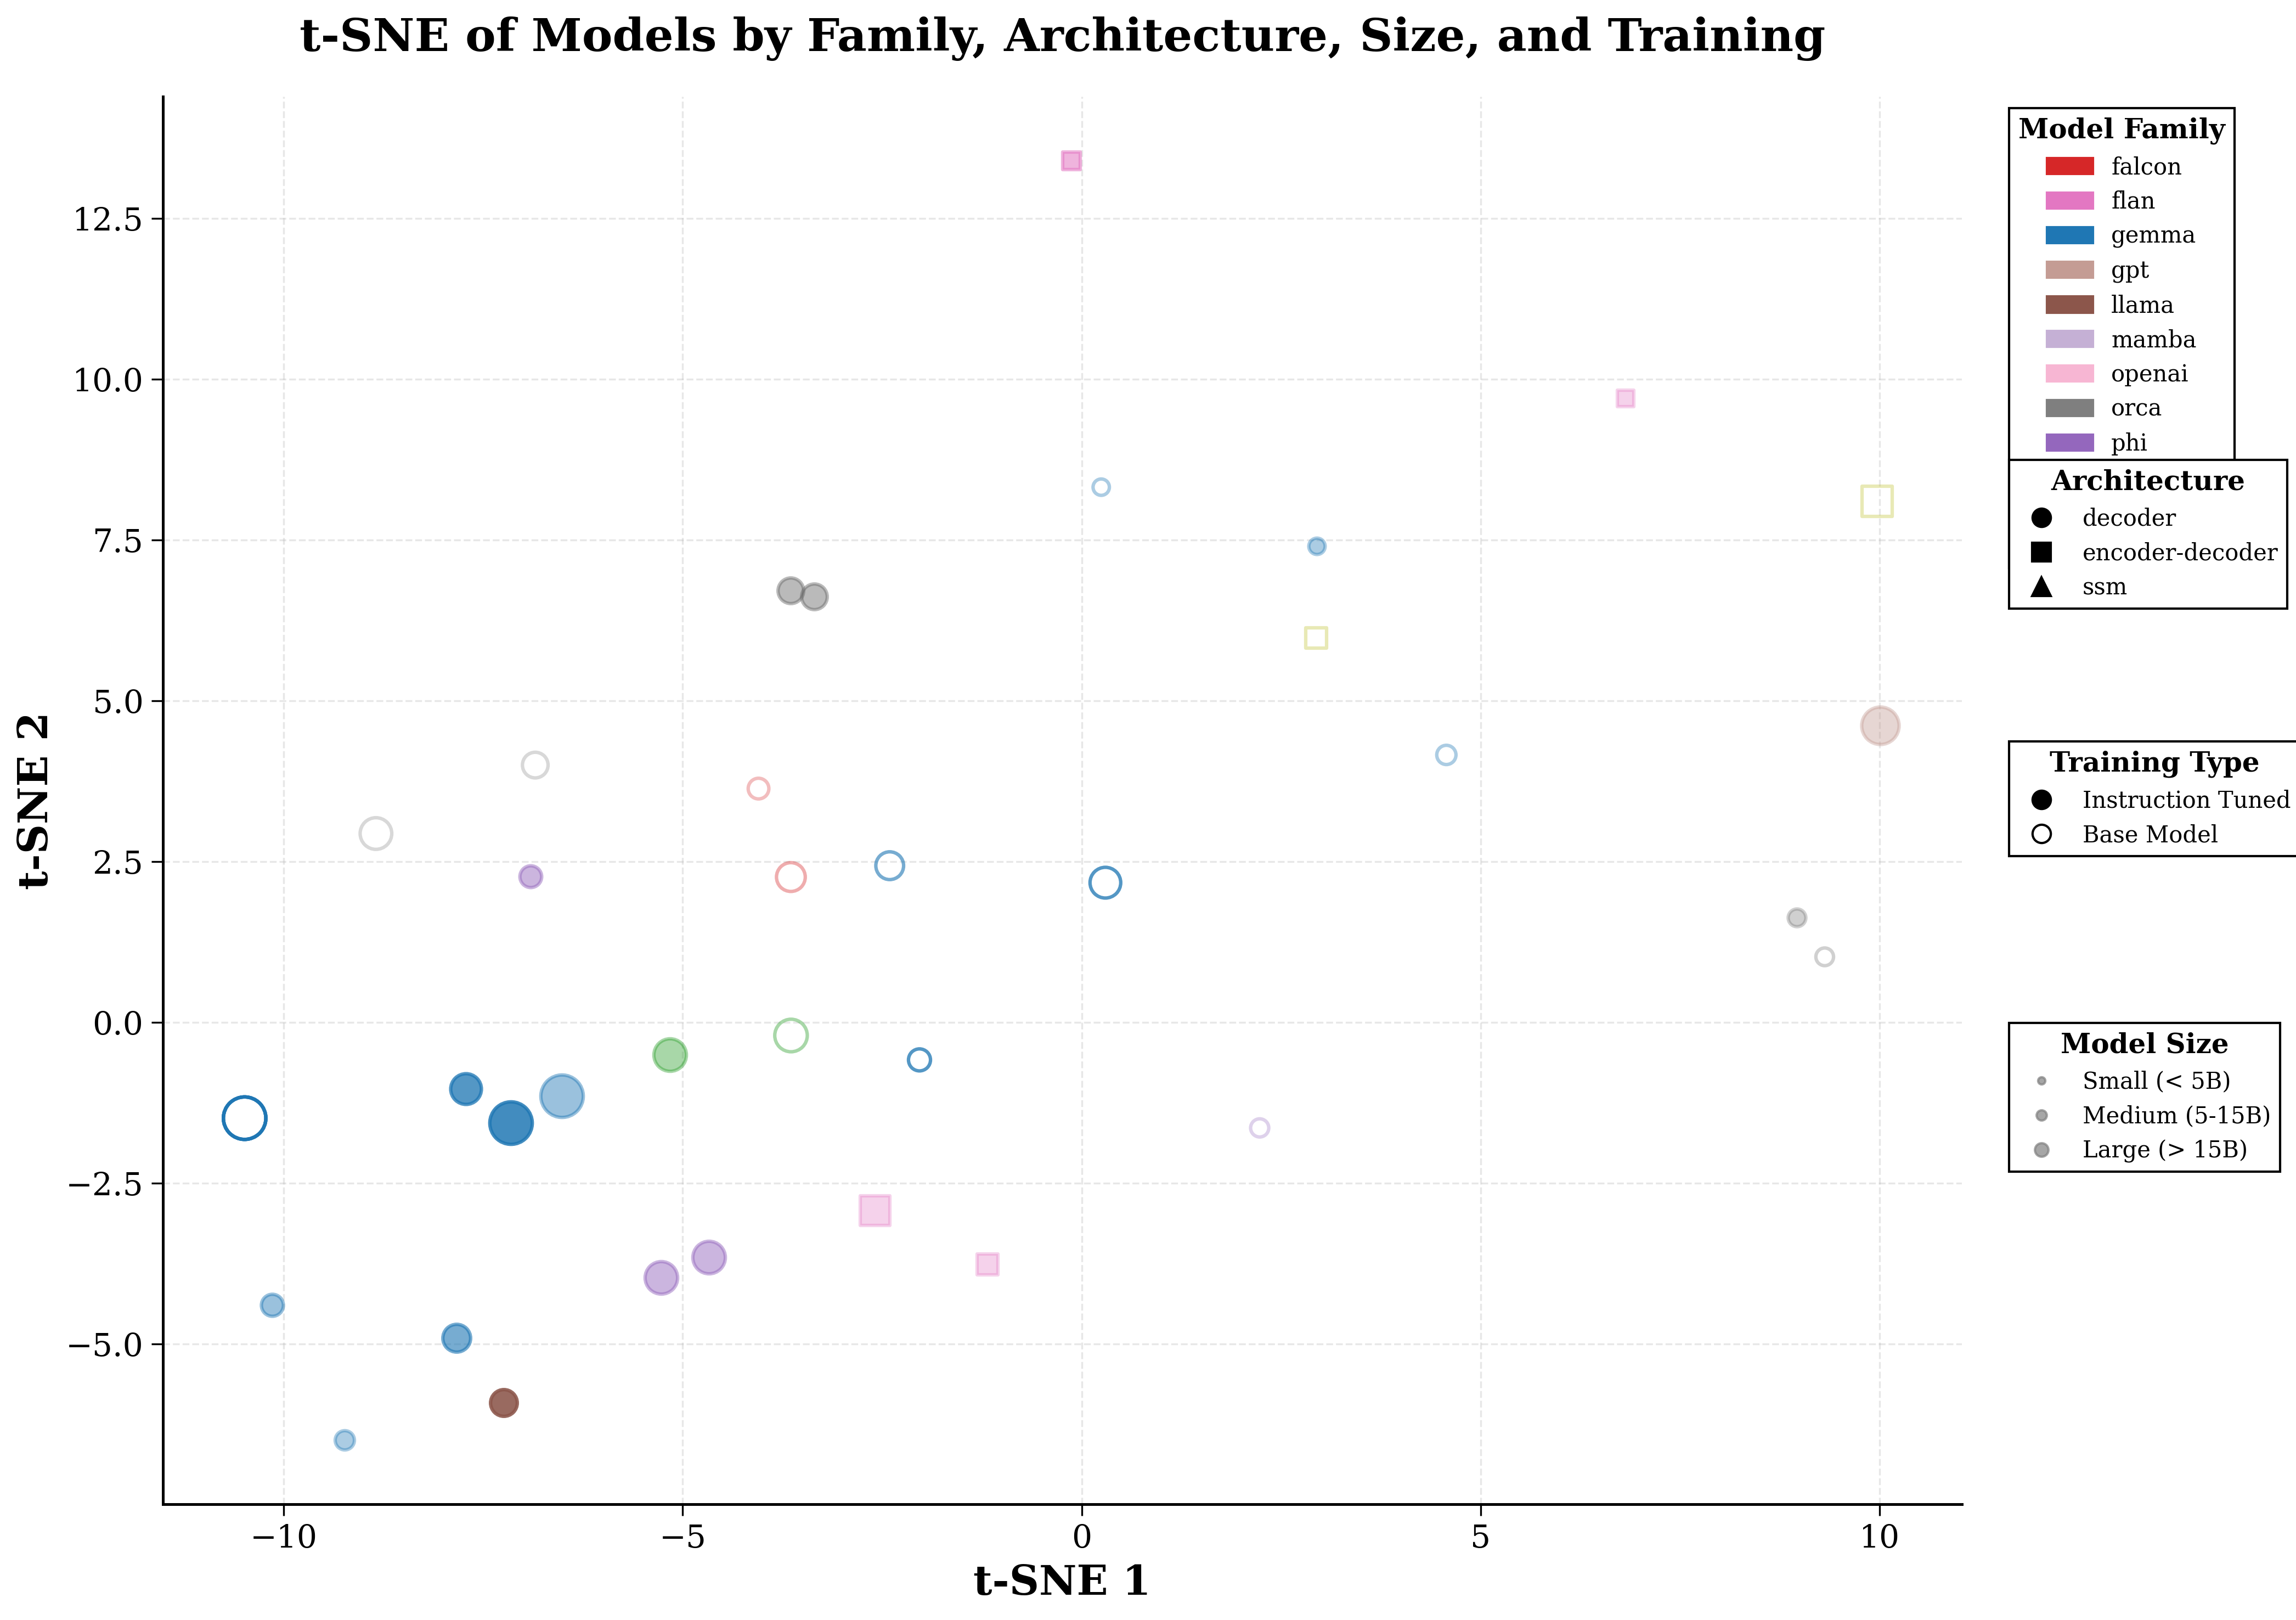

Plots saved in 'plots/' directory:
- tsne_models.png (raster, 300 DPI)
- tsne_models.pdf (vector)
- tsne_models.eps (vector, Illustrator-friendly)
- tsne_models.svg (vector, web-friendly)


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Set style for publication quality
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.frameon': True,
    'legend.fancybox': False,
    'legend.edgecolor': 'black',
    'legend.framealpha': 1.0,
    'figure.dpi': 300
})

def parse_size_value(value_str):
    """Parse size values like '2B', '7B', '0.1B' etc."""
    if not value_str or str(value_str).strip() == '':
        return None
    value_str = str(value_str).strip().upper()
    if value_str.endswith('B'):
        return float(value_str[:-1])
    elif value_str.endswith('T'):
        return float(value_str[:-1]) * 1000
    else:
        try:
            return float(value_str)
        except:
            return None

def parse_training_tokens(tokens_str):
    """Parse training tokens like '2T', '18T', '0.1T' etc."""
    if not tokens_str or str(tokens_str).strip() == '':
        return None
    tokens_str = str(tokens_str).strip().upper()
    if tokens_str.endswith('T'):
        return float(tokens_str[:-1])
    else:
        try:
            return float(tokens_str)
        except:
            return None

def get_family_colors():
    """Define colors for major model families"""
    colors = {
        'gemma': '#1f77b4',
        'OLMo': '#ff7f0e',
        'qwen': '#2ca02c',
        'falcon': '#d62728',
        'phi': '#9467bd',
        'llama': '#8c564b',
        'flan': '#e377c2',
        'orca': '#7f7f7f',
        't5': '#bcbd22',
        'yi': '#17becf',
        'Instella': '#ff9896',
        'mamba': '#c5b0d5',
        'gpt': '#c49c94',
        'openai': '#f7b6d3'
    }
    return colors

def get_architecture_markers():
    """Define markers for different architectures"""
    return {
        'decoder': 'o',
        'encoder-decoder': 's',
        'ssm': '^'
    }

def create_plot(merged_df):
    """Create the t-SNE publication plot"""
    # Extract data
    tsne_x = merged_df['tsne_1'].values
    tsne_y = merged_df['tsne_2'].values
    families = merged_df['family'].values
    parameters = merged_df['parameters'].apply(parse_size_value).values
    training_tokens = merged_df['training_tokens'].apply(parse_training_tokens).values
    architectures = merged_df['architecture'].values
    instruct_tuned = merged_df['instruct_tuned'].values
    
    # Set up the plot with space for legends
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Color/marker mappings
    family_colors = get_family_colors()
    arch_markers = get_architecture_markers()
    
    # Normalize training tokens for opacity (0.3 to 1.0)
    tokens = np.nan_to_num(training_tokens, nan=np.nanmin(training_tokens))
    tokens_norm = (tokens - tokens.min()) / (tokens.max() - tokens.min())
    alphas = 0.3 + 0.7 * tokens_norm
    
    # Normalize parameters (model size) for marker size
    params = np.nan_to_num(parameters, nan=np.nanmin(parameters))
    param_norm = (params - params.min()) / (params.max() - params.min())
    sizes = 50 + 350 * param_norm
    
    # Plot points
    plotted_families = set()
    plotted_architectures = set()
    
    for x, y, family, arch, instruct, alpha, size in zip(
        tsne_x, tsne_y, families, architectures, instruct_tuned, alphas, sizes):
        
        color = family_colors.get(str(family).lower(), '#666666')
        marker = arch_markers.get(arch, 'o')
        facecolor = color if instruct else 'none'
        edgecolor = color
        
        ax.scatter(x, y,
                   s=size,
                   c=facecolor if instruct else 'none',
                   marker=marker,
                   alpha=alpha,
                   edgecolors=edgecolor,
                   linewidths=1.5,
                   zorder=3)
        
        plotted_families.add(str(family).lower())
        plotted_architectures.add(arch)
    
    # Axes
    ax.set_xlabel("t-SNE 1", fontsize=18, fontweight="bold")
    ax.set_ylabel("t-SNE 2", fontsize=18, fontweight="bold")
    ax.set_title("t-SNE of Models by Family, Architecture, Size, and Training",
                 fontsize=20, fontweight="bold", pad=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, alpha=0.3, linestyle="--")
    
    # Legends
    family_handles = []
    for fam in sorted(plotted_families):
        if fam in family_colors:
            family_handles.append(mpatches.Patch(color=family_colors[fam], label=fam))
    
    arch_handles = [plt.Line2D([0], [0], marker=arch_markers[a], color='black',
                               linestyle='None', markersize=8, label=a)
                    for a in sorted(plotted_architectures)]
    
    instruct_handles = [
        plt.Line2D([0], [0], marker='o', color='black', linestyle='None',
                   markersize=8, markerfacecolor='black', label='Instruction Tuned'),
        plt.Line2D([0], [0], marker='o', color='black', linestyle='None',
                   markersize=8, markerfacecolor='none', label='Base Model')
    ]
    
    size_handles = []
    size_labels = ['Small (< 5B)', 'Medium (5-15B)', 'Large (> 15B)']
    size_values = [100, 200, 350]
    for label, size_val in zip(size_labels, size_values):
        handle = plt.Line2D([0], [0], marker='o', color='gray', linestyle='None',
                            markersize=np.sqrt(size_val/10), alpha=0.7, label=label)
        size_handles.append(handle)
    
    # Stack legends to the right
    legend1 = ax.legend(handles=family_handles, title='Model Family',
                        title_fontsize=12, fontsize=10,
                        loc='upper left', bbox_to_anchor=(1.02, 1.0),
                        frameon=True, fancybox=False, edgecolor='black')
    legend1.get_title().set_fontweight('bold')
    
    legend2 = ax.legend(handles=arch_handles, title='Architecture',
                        title_fontsize=12, fontsize=10,
                        loc='upper left', bbox_to_anchor=(1.02, 0.75),
                        frameon=True, fancybox=False, edgecolor='black')
    legend2.get_title().set_fontweight('bold')
    
    legend3 = ax.legend(handles=instruct_handles, title='Training Type',
                        title_fontsize=12, fontsize=10,
                        loc='upper left', bbox_to_anchor=(1.02, 0.55),
                        frameon=True, fancybox=False, edgecolor='black')
    legend3.get_title().set_fontweight('bold')
    
    legend4 = ax.legend(handles=size_handles, title='Model Size',
                        title_fontsize=12, fontsize=10,
                        loc='upper left', bbox_to_anchor=(1.02, 0.35),
                        frameon=True, fancybox=False, edgecolor='black')
    legend4.get_title().set_fontweight('bold')
    
    # Re-add previous legends
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    ax.add_artist(legend3)
    
    # Layout
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)
    return fig, ax

if __name__ == "__main__":
    fig, ax = create_plot(merged_df)
    
    plt.savefig('tsne_models.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('tsne_models.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('tsne_models.eps', bbox_inches='tight',
                facecolor='white', edgecolor='none', format='eps')
    plt.savefig('tsne_models.svg', bbox_inches='tight',
                facecolor='white', edgecolor='none', format='svg')
    
    plt.show()
    
    print("Plots saved in 'plots/' directory:")
    print("- tsne_models.png (raster, 300 DPI)")
    print("- tsne_models.pdf (vector)")
    print("- tsne_models.eps (vector, Illustrator-friendly)")
    print("- tsne_models.svg (vector, web-friendly)")
